In [188]:
import json
import pandas as pd
import os
import copy
from pathlib import Path
import matplotlib.pyplot as plt
plt.style.use('seaborn')
from matplotlib import dates as mpl_dates
import seaborn as sns

from thermal_tank.tank_bypass_branch import TankBypassBranch, OpMode
from thermal_tank.mpc import *
from thermal_tank.compare_op_strategy import *

controls_path = Path().resolve()

In [189]:
pv_output = pd.read_parquet(thermal_tank_log_dir / ".." / "pv.parquet")["pv_kw"].values
pv_size_kw = 150
pv_output *= pv_size_kw
pv_output = np.array(list(pv_output) + [pv_output[0]])

In [201]:
def read_results(filepath):
    df = pd.read_parquet(filepath).reset_index()
    df['DateTime'] = pd.to_datetime(df['DateTime'])
    opt_col = [c for c in df['run'].unique() if 'optimized' in c][0]
    df = df.replace({opt_col: "optimized"})
    n_runs = len(df['run'].unique())
    df['bldg_elec_load'] = (day_avg_bldg_load + day_avg_bldg_load[0:1]) * n_runs
    df['loop_inlet_temp'] -= 273.15
    df['loop_outlet_temp'] -= 273.15
    df['tank_temp'] -= 273.15
    df['chiller_outlet_temp'] -= 273.15
    old_max_chload = df[df['run'] == 'schedule']['chiller_power'].max()
    new_max_chload = df[df['run'] != 'schedule']['chiller_power'].max()
    old_max_load = df[df['run'] == 'schedule']['bldg_load'].max()
    new_max_load = df[df['run'] != 'schedule']['bldg_load'].max()
    n = len(df) // n_runs

    df['bldg_elec_load_pv'] = df['bldg_elec_load'] - list(pv_output) * n_runs
    df_single = df[df['run'] == 'schedule']
    load_calc = 'bldg_elec_load_pv' if 'pv' in str(filepath) else 'bldg_elec_load'
    max_loads_times = df_single[df_single[load_calc].values == df_single[load_calc].values.max()].index.values

    res_info = {
        "old_max_chload": old_max_chload,
        "new_max_chload": new_max_chload,
        "old_max_load": old_max_load,
        "new_max_load": new_max_load,
        "max_loads_times": max_loads_times
    }    
    return df, df_single, res_info

orig_path = Path(controls_path / "opt_results.parquet")
pv_path = Path(controls_path / "opt_150pv_results.parquet")
pv_peak_path = Path(controls_path / "opt_150pv_2peak_results_202.parquet")

orig_df, orig_df_single, orig_info = read_results(orig_path)
pv_df, pv_df_single, pv_info = read_results(pv_path)
pv_peak_df, pv_peak_df_single, pv_peak_info = read_results(pv_peak_path)

for name in (orig_df, pv_df, pv_peak_df):
    name['pv_150kw'] = np.tile(pv_output, len(name['run'].unique()))

In [202]:
def plot_comparison(df, y_vals, titles, ylabels, mark_max_load=False, max_loads_times=[]):
    if mark_max_load is False:
        mark_max_load = [False] * len(y_vals)
    fig, axs = plt.subplots(len(y_vals), 1, figsize=(16, 3 * len(y_vals)), sharex=True)
    for n, ax in enumerate(axs):
        sns.lineplot(data=df, x='DateTime', y=y_vals[n], hue='run', ax=ax, 
            palette=['grey', 'blue', 'orange'][:len(df['run'].unique())],
            style='run',
            dashes={'schedule': "", 'optimized': '', 'simulate': (2, 2)}
            )
        date_format = mpl_dates.DateFormatter('%D %H-%M')
        ax.xaxis.set_major_formatter(date_format)
        ax.set_title(titles[n])
        ax.set_ylabel(ylabels[n])
        if mark_max_load[n]:
            for ts in max_loads_times:
                ax.axvspan(df.DateTime.values[ts-1], df.DateTime.values[ts+1], alpha=0.3, color='red')
    fig.autofmt_xdate()


# Comparing the Schedule-Based Control with the MPC Control

<!-- <img src="TES_flow.png" width="800"> -->
![TES flow diagram](TES_flow.png)

The system being optimized is shown in the flow diagram. There's a Building that has a Chilled Water Loop which consists of a chiller in series with a TES and bypass flow that mixes with the TES outlet. The Chilled Water Loop's outlet fluid flows through the building and warms up, returning to the inlet with some "Bldg Delta T". The building also has a Electric-only Load.

The goldenrod rectangular nodes show components with control variables: the chiller's outlet temperature and the TES's outlet temperature. The gray node of the Building indicates it's a fixed input, noncontrollable. The nodes contain variables that will be modified downstream of the control actions.

This notebook shows the control optimization of this system to reduce the Building's Total Load Peak across the entire day. The Total Load consists of the Electric-only Load + the Chiller Load. The model controls the Chiller outlet temperature and TES outlet temperature so that the Chilled-Water-Loop's outlet temperature is less than 8 degrees C.

The Building's thermal load (Delta T) and electric-only load are inputs to this model, and is pulled from an EnergyPlus simulation's average day. The chiller power consumption is a function of the chiller's delta T and the ambient temperature.

### Load Plots

The Bldg Delta T plot below shows how much the building warms up the loop fluid per (15-min) time step. The Electric-only load is shown on the top. Both of these are inputs and are not controllable.

The red highlighted areas are the peak loads in the Building Electric-Only Load (~72 kW).

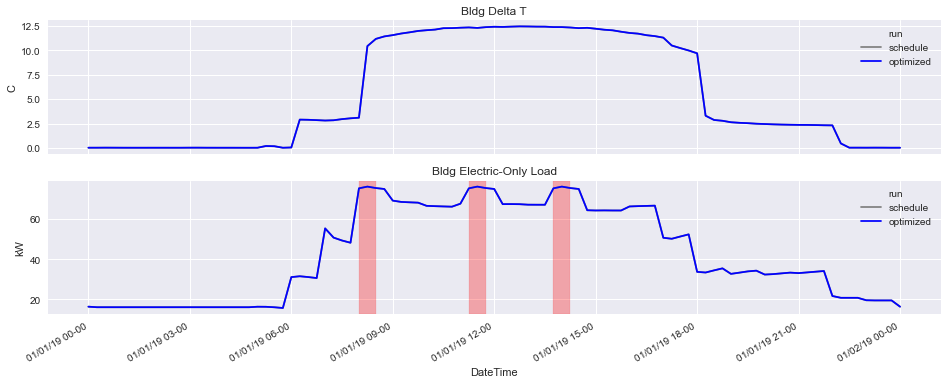

In [203]:
plot_comparison(orig_df, ['bldg_delta_T', 'bldg_elec_load'], ['Bldg Delta T', 'Bldg Electric-Only Load'], ['C', 'kW'], 
    [False, True], orig_info['max_loads_times'])

## Comparison of Schedule-based Control vs MPC

The Schedule-based Control consists of defining outlet temperature setpoints for the Chiller and the TES during Charge Mode and Discharge Mode. For example, to Discharge from 8am to 6pm, the Chiller's setpoint would be 7.7 C, and the TES would discharge to so that the Chilled-Water-Loop temperature meets the setpoint of 7.2 C. Then to Charge from 10pm to 8am, the Chiller's setpoint would be -3.8 C and the TES would charge, still ensuring the loop setpoint is met.

The MPC uses a mixed-integer nonlinear program to optimize the operation for, in this example, the lowest daily demand, which flattens the load over the day.

In the plots below, the gray lines are from the schedule, and the blue ones are from MPC.

### Chiller Load and Building Total Load

On the upper plot, the schedule control results in a large peak of chiller power at 6pm, when the chiller's setpoint is changed from 7.7 to -3.8 C. The reason this takes so much power is because the circulating fluid at that time is around 4-5 C, so reducing that to -3.8 is costly.

On the lower plot, the total building load is shown. After the large peak at 6pm, the next highest load times occur around 7am and 8-9am. During these times, the schedule control has a non-zero chiller power: 25 kW around 7am and 3 kW around 8-9am.

With the MPC, the total building load is reduced from 235 kW to 151 kW, a 35.7% peak reduction. The 6pm peak is eliminated, and the highest power use occurs at 8-9am, and is purely from electric-only load as the optimized chiller load is 0 during this time.

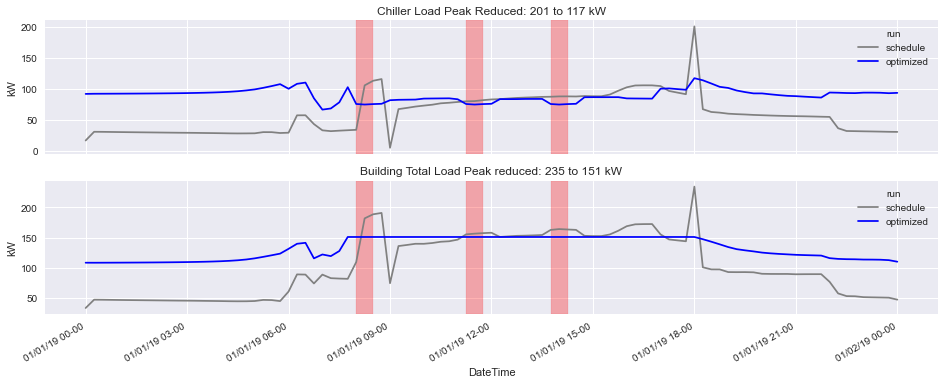

In [204]:
plot_comparison(orig_df, ['chiller_power', 'bldg_load'], 
    [f"Chiller Load Peak Reduced: {round(orig_info['old_max_chload'])} to {round(orig_info['new_max_chload'])} kW", 
    f"Building Total Load Peak reduced: {round(orig_info['old_max_load'])} to {round(orig_info['new_max_load'])} kW"], ['kW', 'kW'], 
    [True, True], orig_info['max_loads_times'])

### Delta T

The building's increased Delta T needs to be matched by the Chiller and TES' Delta T in order for the fluid to stay within the chilled water loop setpoint. The plots below show how the chiller and TES splits up the Delta T.

In the optimized control, the Chiller Delta T is increased to reduce the Bldg Elec Load's 3 bumps of peak power around 8am, 11am and 2pm. The Chiller Delta T is also smoother.

In the schedule control, the tank's Delta T is much lower, meaning greater discharge, during the middle of the day. During charging of the tank, the positve Delta T is rather steady except around 6am and 6pm, when the tank is cooling ice and when the elec load decreases, respectively.

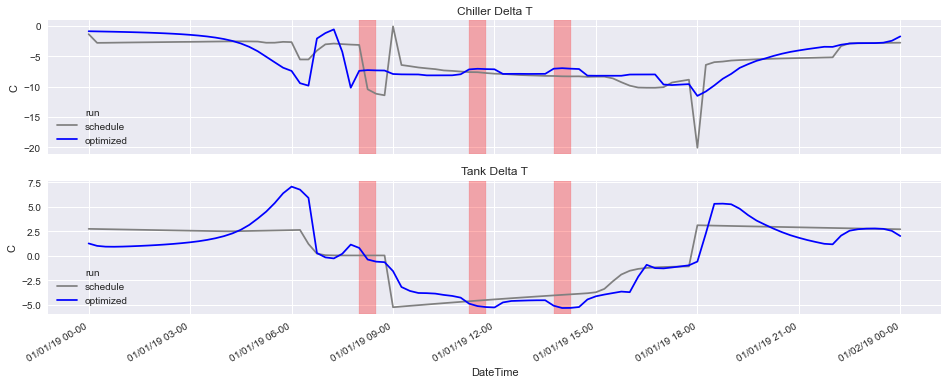

In [205]:
plot_comparison(orig_df, ['chiller_delta_T', 'tank_delta_T'], ['Chiller Delta T', 'Tank Delta T'], ['C', 'C'], [True, True], orig_info['max_loads_times'])


### TES Operation

Looking at the TES operation, we see in the first plot the temperature of the chiller outlet and tank inlet. During the peak hours, the chiller allows its outlet fluid to drift to a higher temperature.

In the second plot, the Tank Delta T shows that the TES steps up to reduce that higher chiller outlet temperature. 

In the bottom two plots, the Ice-Only SOC and Tank Temperature is shown. The Ice-Only SOC is 1 when it is all ice and 0 it is all water. The TES finishes making ice at around 7am and continues cooling the ice, and then discharges a little before cooling the ice again. Then it begins a continuous discharge between 8am until 6pm.

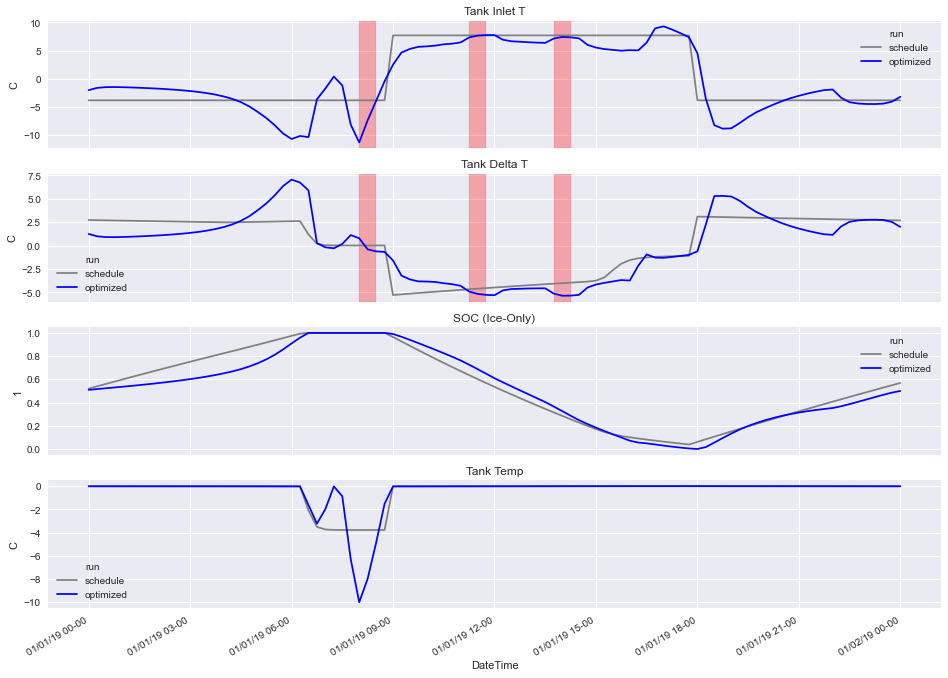

In [206]:
plot_comparison(orig_df, ['chiller_outlet_temp', 'tank_delta_T', 'soc', 'tank_temp'], 
                ['Tank Inlet T', 'Tank Delta T', 'SOC (Ice-Only)', 'Tank Temp'], ['C', 'C', '1', 'C'], 
                [True, True, False, False], orig_info['max_loads_times'])


# Thoughts on Sizing the TES

The TES is being used to its full capacity in this day. The load during the middle of the day is still noticeably higher than the rest of the day, and the chiller load is not zero during the middle of the day either. A larger TES would be able to flatten the load out even further.

# Adding PV

A day-average PV generation profile is compiled from an annual simulation and used to add a 150-kW PV system that reduces the load.

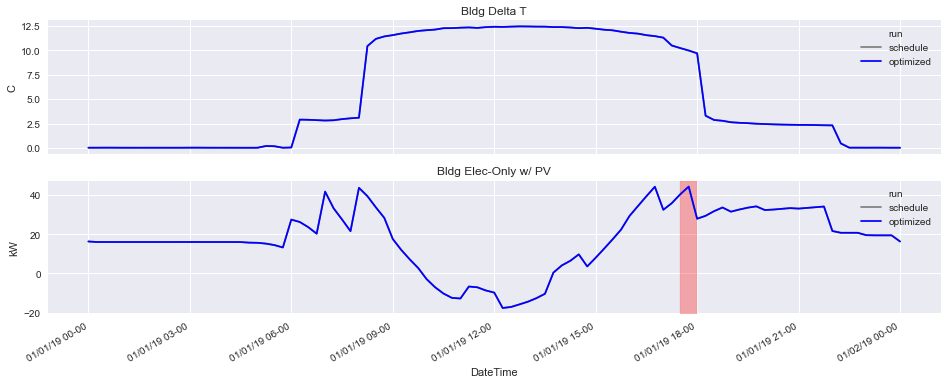

In [207]:
plot_comparison(pv_df, ['bldg_delta_T', 'bldg_elec_load_pv'], ['Bldg Delta T', 'Bldg Elec-Only w/ PV'], ['C', 'kW'], 
    [False, True], pv_info['max_loads_times'])

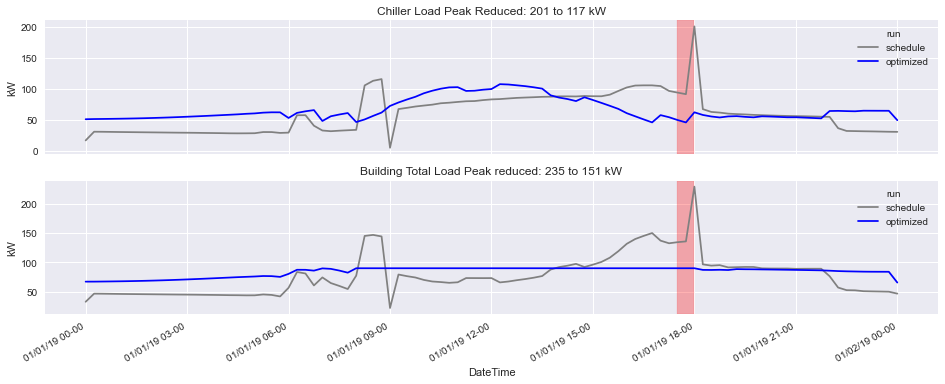

In [208]:
plot_comparison(pv_df, ['chiller_power', 'bldg_load'], 
    [f"Chiller Load Peak Reduced: {round(orig_info['old_max_chload'])} to {round(orig_info['new_max_chload'])} kW", 
    f"Building Total Load Peak reduced: {round(orig_info['old_max_load'])} to {round(orig_info['new_max_load'])} kW"], ['kW', 'kW'], 
    [True, True], pv_info['max_loads_times'])

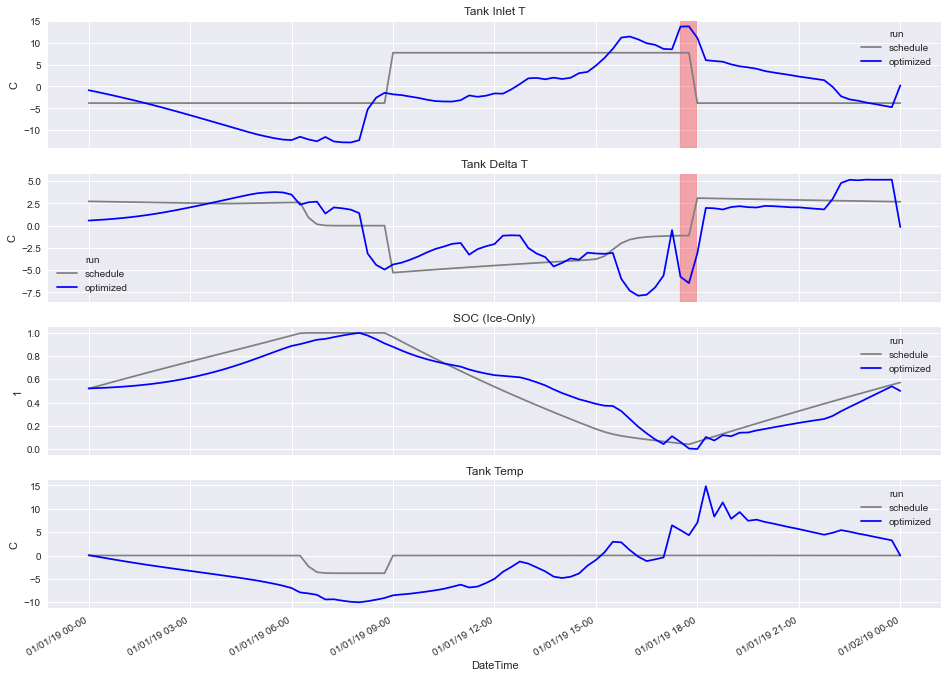

In [209]:
plot_comparison(pv_df, ['chiller_outlet_temp', 'tank_delta_T', 'soc', 'tank_temp'], 
                ['Tank Inlet T', 'Tank Delta T', 'SOC (Ice-Only)', 'Tank Temp'], ['C', 'C', '1', 'C'], 
                [True, True, False, False], pv_info['max_loads_times'])

# Adding PV with a TOU period

In addition to a monthly demand charge, there is also a TOU peak period from 1 - 7pm during which demand price is higher.

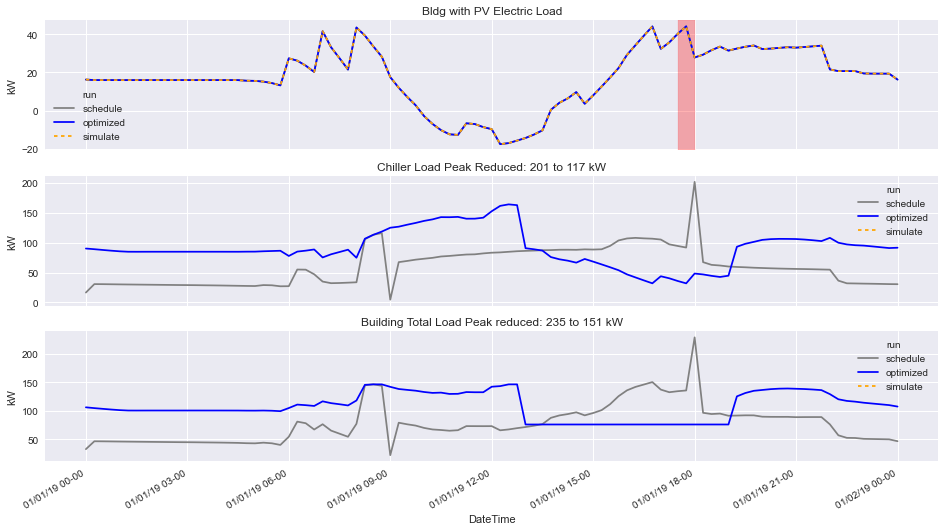

In [210]:
plot_comparison(pv_peak_df, ['bldg_elec_load_pv', 'chiller_power', 'bldg_load'], 
    ["Bldg with PV Electric Load",
        f"Chiller Load Peak Reduced: {round(orig_info['old_max_chload'])} to {round(orig_info['new_max_chload'])} kW", 
        f"Building Total Load Peak reduced: {round(orig_info['old_max_load'])} to {round(orig_info['new_max_load'])} kW"], ['kW', 'kW', 'kW'], 
    [True, False, False], pv_peak_info['max_loads_times'])

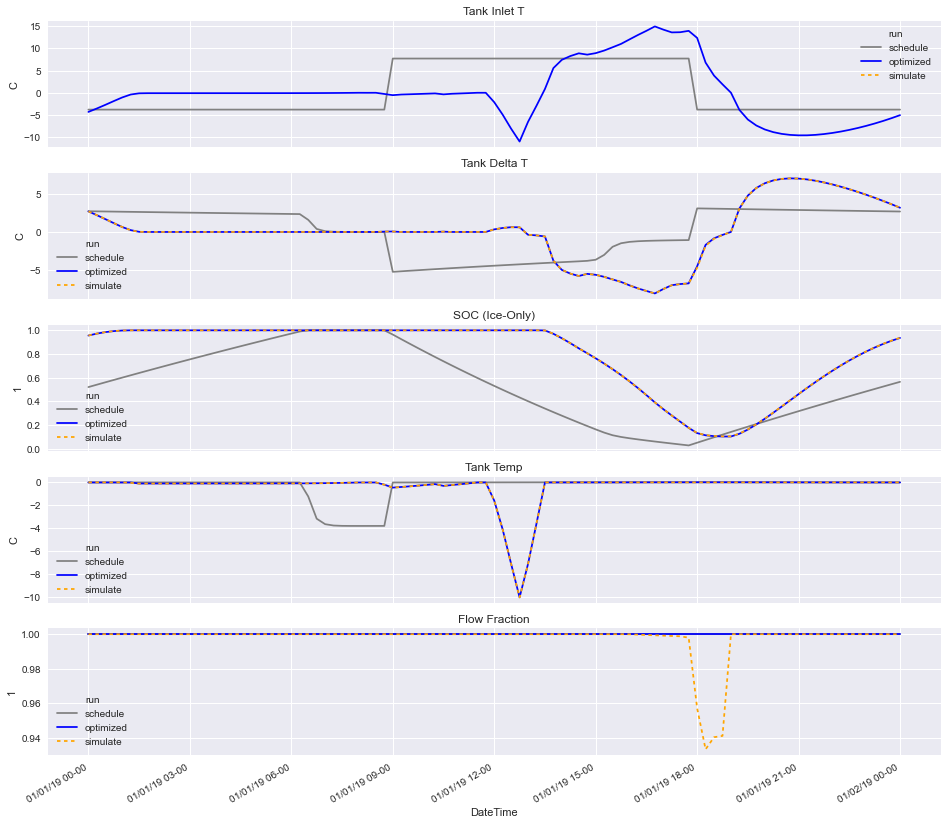

In [211]:
# pv_peak_df = pv_peak_df[pv_peak_df.DateTime.isin(np.sort(pv_peak_df.DateTime.unique())[60:70])]
plot_comparison(pv_peak_df, ['chiller_outlet_temp', 'tank_delta_T', 'soc', 'tank_temp', 'tank_flow_fraction'], 
                ['Tank Inlet T', 'Tank Delta T', 'SOC (Ice-Only)', 'Tank Temp', "Flow Fraction"], 
                ['C', 'C', '1', 'C', '1'], 
                [False, False, False, False, False], pv_peak_info['max_loads_times'])